<font size="5">directory and file import: 2208XX data</font>

In [246]:
from __future__ import division
import sys,os
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import scipy
import scipy.optimize as opt
#import matplotlib.patches as mpatches
import h5py
sys.path.append('../PyMKID-master')
import PyMKID_USRP_functions as PUf
import PyMKID_resolution_functions as Prf
from scipy.signal import periodogram,get_window,coherence,welch,csd
import scipy.signal as sig
from scipy.interpolate import interp1d
import time 
import MB_equations as MBe
import MB_analysis as MBa
from matplotlib.lines import Line2D
from pandas import *
from importlib import reload

date_directory = '220815 laser data/'

power_directories = ['-25/',\

                                         # '-30/'
                    ]


# NDF_directories = [\
# #                    # '15V/',\
# #                    # '15V 10us/',\
#                    '18V 10us/',\
#                    '18V 22us/',\
#                    '18V 35us/',\
#                    '18V 48us/',\
#                    '18V 60us/',\
#                    # '18V 60us/'\
                  # ]
# NDF_directories = [\
# #                    # '15V/',\
# #                    # '15V 10us/',\
#                    # '18V 10us/',\\
#                    '',\
#                    '14V 50us/',\
#                    '18V 50us/',\
#                    # '18V 48us/',\
#                    # '18V 60us/',\
#                    # '18V 60us/'\
#                   ]

NDF_directories = [\
                   '',\
                   '0V 50us/',\
                   '1V 50us/',\
                   '2V 50us/',\
                   '3V 50us/',\
                   '4V 50us/',\
                   '5V 50us/',\
                   '6V 50us/',\
                   '7V 50us/',\
                   '8V 50us/',\
                   '9V 50us/',\
                   '10V 50us/',\
                   '11V 50us/',\
                   '12V 50us/',\
                   '13V 50us/',\
                   '14V 50us/',\
                   '15V 50us/',\
                   '16V 50us/',\
                   '17V 50us/',\
                   '18V 50us/'\
                  ]
# NDF_directories = [\
                   # '0V 35us/',\
                   # '1V 35us/',\
                   # '2V 35us/',\
                   # '3V 35us/',\
                   # '4V 35us/',\
                   # '5V 35us/',\
                   # '6V 35us/',\
                   # '7V 35us/',\
                   # '8V 35us/',\
                   # '9V 35us/',\
                   # '10V 35us/',\
                   # '11V 35us/',\
                   # '12V 35us/',\
                   # '13V 35us/',\
                   # '14V 35us/',\
                   # '15V 35us/',\
                   # '16V 35us/',\
                   # '17V 35us/',\
                   # '18V 35us/'\
                   # '0V 60us/',\
                   # '1V 60us/',\
                   # '2V 60us/',\
                   # '3V 60us/',\
                   # '4V 60us/',\
                   # '5V 60us/',\
                   # '6V 60us/',\
                   # '7V 60us/',\
                   # '8V 60us/',\
                   # '9V 60us/',\
                   # '10V 60us/',\
                   # '11V 60us/',\
                   # '12V 60us/',\
                   # '13V 60us/',\
                   # '14V 60us/',\
                   # '15V 60us/',\
                   # '16V 60us/',\
                   # '17V 60us/',\
                   # '18V 60us/'\
                  # ]

power_NDF_noise_files, power_NDF_pulse_files, power_NDF_pulse_vna_files, power_NDF_noise_vna_files, power_NDF_char_files = [], [], [], [], []
for power_directory in power_directories:
    NDF_noise_files, NDF_pulse_files, NDF_noise_vna_files,NDF_pulse_vna_files, NDF_char_files = [], [], [], [], []
    for NDF_directory in NDF_directories:
        directory = date_directory + power_directory + NDF_directory
        objects = sorted(os.listdir(directory))

        noise_counter = 0 
        for fm in range(len(objects)):
            if objects[fm][-3:] == '.h5':
                if 'USRP_Noise_' in objects[fm] and not 'cleaned' in objects[fm]:
                    NDF_noise_files += [directory + objects[fm]]
                elif '_VNA_' in objects[fm]:
                    NDF_pulse_vna_files += [directory + objects[fm]]
                    NDF_noise_vna_files += [directory + objects[fm]]
                elif 'USRP_Laser_' in objects[fm] and not 'cleaned' in objects[fm]:
                    NDF_pulse_files += [directory + objects[fm]]
                elif 'noise_averages' in objects[fm]:
                    NDF_char_files += [directory + objects[fm]]
    power_NDF_noise_files.append(NDF_noise_files)
    power_NDF_noise_vna_files.append(NDF_noise_vna_files)
    power_NDF_pulse_files.append(NDF_pulse_files)
    power_NDF_pulse_vna_files.append(NDF_pulse_vna_files)
    power_NDF_char_files.append(NDF_char_files)

<font size="5">noise cleaning to get cleaning coefficients</font>

will separate the data into  1000 chunks to achieve the requested 1.00e+02 lower end of the PSD
additional decimation by 5 needed to achieve the requested 5.00e+04 upper end of the PSD
doing additional decimation
sampling frequency plugged into welch is 50000
pulse time data already exists! If you set override=False, nothing will happen.
saving pulse time data to 220815 laser data/-25/USRP_Noise_20220815_154748.h5 because override=True!
found 1 pulses
chunk length plugged into welch is 500
chunked data into 1000 timestreams
computed electronics basis
cleaning...
(2, 349500)
(1, 349500)
(1, 349500)
(2, 349500)
(1, 349500)
(1, 349500)
saving clean_data to 220815 laser data/-25/USRP_Noise_20220815_154748_cleaned.h5 because override=True!
number of chunks used to average is 699


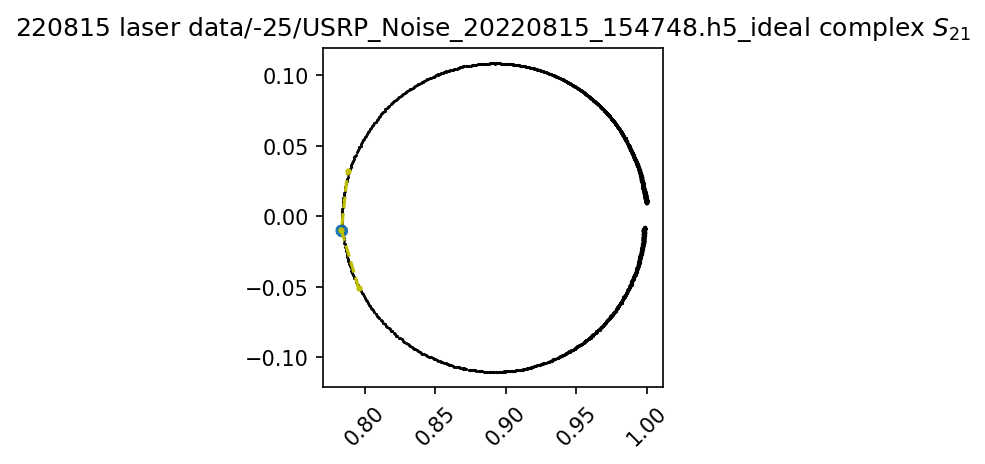

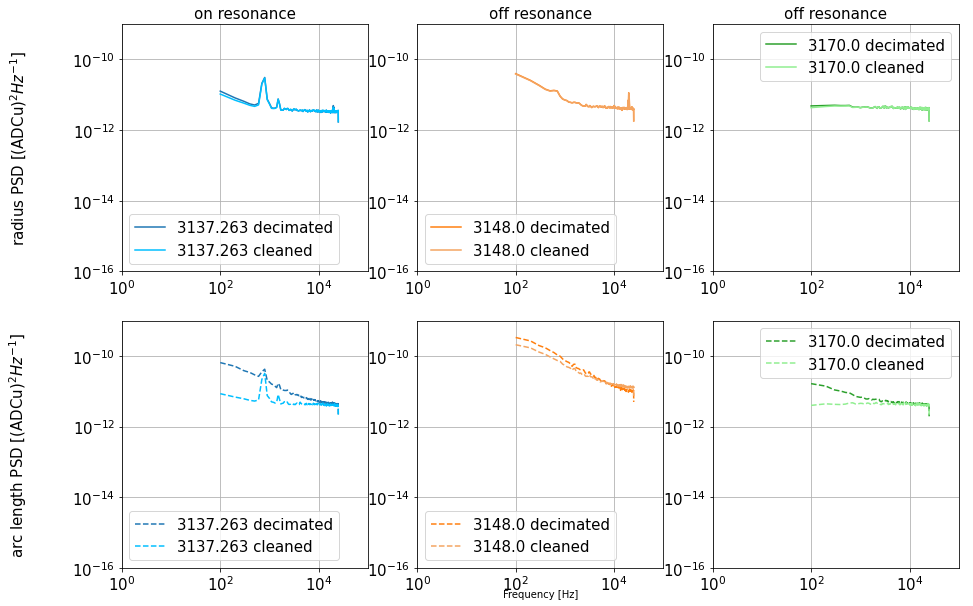

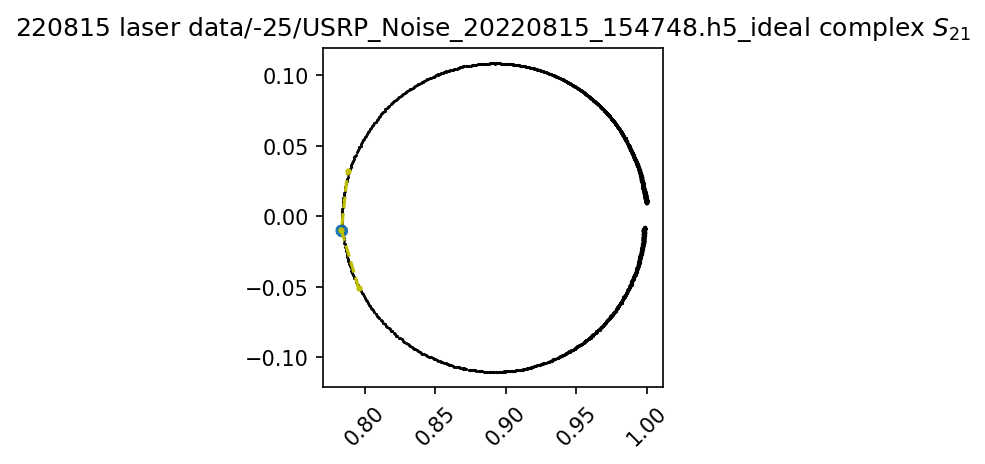

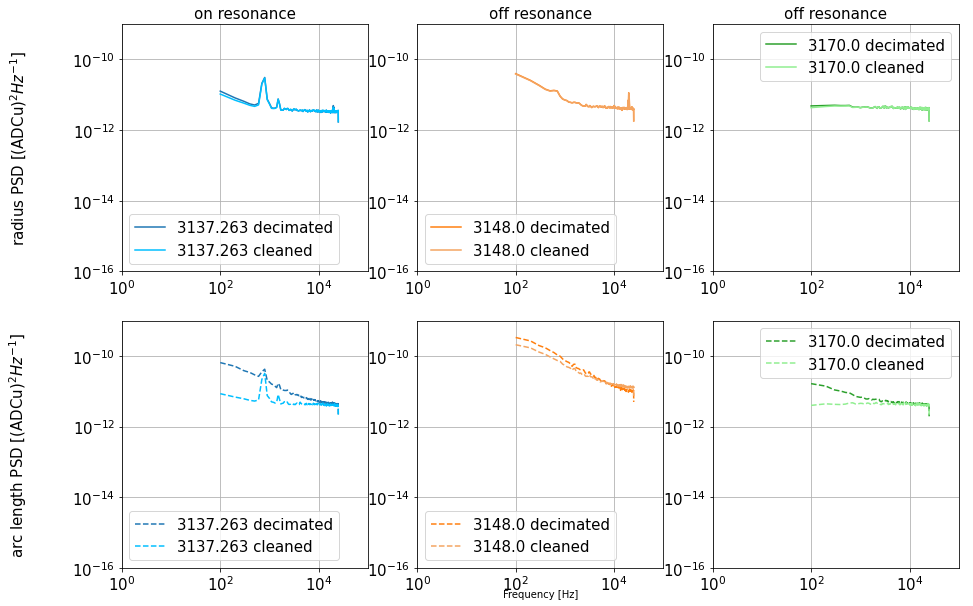

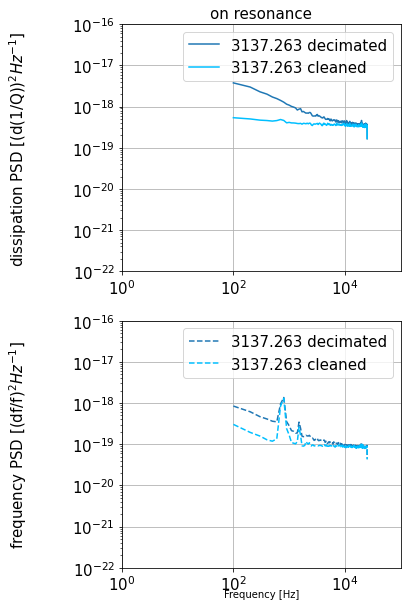

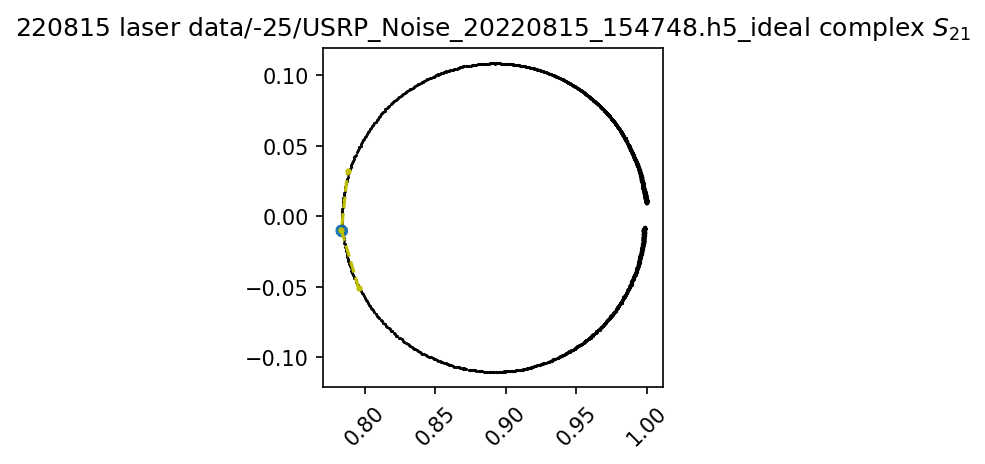

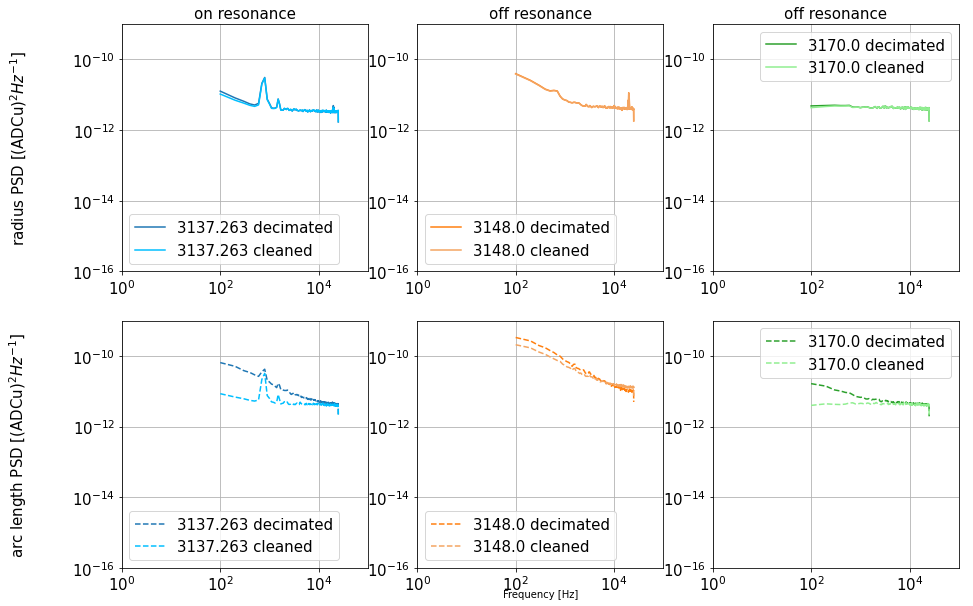

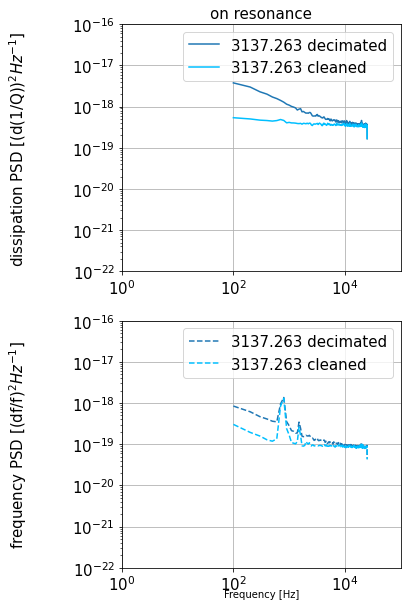

In [278]:
chunk_up_to = 1*10**2
decimate_down_to = 5*10**4
i = 0
reload(Prf)
for noise_file,vna_file,char_file in zip(power_NDF_noise_files[0],power_NDF_noise_vna_files[0],power_NDF_char_files[0]):
    # print('\n\n\n\n\n\n\n~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~`')
    # print('power: ' + power_directories[i])
    _, noise_info = PUf.unavg_noi(noise_file)
    noise_total_time =  noise_info['time'][-1]
    noise_fs = 1./noise_info['sampling period']
    noise_readout_f = noise_info['search freqs'][0]

    num_chunks = int(noise_total_time*chunk_up_to)
    noise_decimation = int(noise_fs/decimate_down_to)

    print('===================================')
    print('will separate the data into  ' + str(num_chunks) +  ' chunks to achieve the requested '  + "{:.2e}".format(chunk_up_to) + ' lower end of the PSD')
    print('===================================')
    print('additional decimation by ' + str(noise_decimation) +  ' needed to achieve the requested ' + "{:.2e}".format(decimate_down_to) + ' upper end of the PSD')
    print('===================================')

    with h5py.File(char_file,'r') as fyle:
        char_points = np.array(fyle['means'])
        char_f = np.array(fyle['frequencies'])
        readout_f = char_f[1]

    powers, PSDs, res, timestreams = Prf.PSDs_and_cleaning(noise_file,\
                                                           vna_file,\
                                                           extra_dec = noise_decimation,\
                                                           num_chunks=num_chunks,\
                                                           blank_chunks=int(num_chunks*0.3),\
                                                           removal_decimation = 1,\
                                                           char_fs=char_f,char_zs=char_points\
                                                           )
    i += 1

<font size="5">pulse cleaning</font>


In [247]:
total_pulses = 100*10
decimate_down_to = 5e4
blank_fraction = 0.3
time_btw_pulse = 10e-3
num_pulses = int(total_pulses * (1 - blank_fraction))
# fraction_to_keep = 0.5

# num_pulses = 250*10
i = 0 
verbose = False
for NDF_pulse_files,NDF_noise_files,NDF_pulse_vna_file in zip(power_NDF_pulse_files,power_NDF_noise_files,power_NDF_noise_vna_files):
    # print('power: ' + power_directories[i])
    if len(NDF_pulse_files) != len(NDF_noise_files):
        NDF_noise_files = len(NDF_pulse_files) * NDF_noise_files
        NDF_pulse_vna_files = len(NDF_pulse_files) * NDF_pulse_vna_file
    for pulse_file,vna_file, noise_file in zip(NDF_pulse_files,NDF_pulse_vna_files,NDF_noise_files):
        print('===================')
        print('cleaning pulse file: ' + pulse_file)
        print('===================')

        pulse_noise, pulse_info = PUf.unavg_noi(pulse_file)
        pulse_fs = 1./pulse_info['sampling period']
        pulse_cleaning_decimation = int(pulse_fs/decimate_down_to)
        
        if verbose:
            print('loaded pulse data')
            print('===================')

        pulse_noise = Prf.average_decimate(pulse_noise,pulse_cleaning_decimation)
        pulse_fs /= pulse_cleaning_decimation
        
        print('decimated data by ' + str(pulse_cleaning_decimation) + ' to achieve requested upper bound of ' + '{:2e}'.format(decimate_down_to) + ' Hz' )
        print('===================')

        samples_per_pulse = int(time_btw_pulse*pulse_fs)
        N = int(samples_per_pulse / 2)
        pulse_start = int(total_pulses * blank_fraction)
        window_shift_seconds = -10e-6
        window_shift = int(window_shift_seconds * pulse_fs)
        noise_averages = np.zeros((3),dtype=np.complex128)
        for pulse_i in range(pulse_start,int(total_pulses),1):                
            pulse_i_end = int((pulse_i+1)*samples_per_pulse) 
            no_pulse_idx_start = pulse_i_end - N + window_shift
            no_pulse_idx_end = pulse_i_end + window_shift

            noise_averages += np.mean(pulse_noise[no_pulse_idx_start:no_pulse_idx_end,:],axis=0,dtype=np.complex128) / num_pulses    
            
            
        print('used ' + str(k) + ' chunks to find quiescent point')
        # print(noise_averages)
        radius_averages = abs(noise_averages)
        angle_averages = np.angle(noise_averages)
        if verbose:
            print(radius_averages)
            print(angle_averages)

        pulse_timestream_rotated = pulse_noise*np.exp(-1j*angle_averages)
        angle_timestream = np.angle(pulse_timestream_rotated)

        radius = abs(pulse_noise) - radius_averages
        arc = angle_timestream*radius_averages

        radius_clean = np.zeros(radius.shape)
        arc_clean = np.zeros(arc.shape)

        if verbose:
            print('built radius and arc length timestreams given by quiescent point')
            print('===================')

            print(noise_file)
        _,data_info = PUf.clean_noi(noise_file[:-3]+'_cleaned.h5')

        for t in range(radius.shape[1]):
            radius_coefficient = data_info['radius cleaning coefficient'][t]
            arc_coefficient = data_info['arc cleaning coefficient'][t]

            if t == 0:
                off_tone_idcs = [1,2]
            elif t == 1:
                off_tone_idcs = [2]
            elif t == 2:
                off_tone_idcs = [1]


            off_tone_radius = np.mean(radius[:,off_tone_idcs],axis=1,dtype=np.float64)
            radius_clean[:,t]= radius[:,t] - radius_coefficient*off_tone_radius

            off_tone_arc = np.mean(arc[:,off_tone_idcs],axis=1,dtype=np.float64)
            arc_clean[:,t] = arc[:,t] - arc_coefficient*off_tone_arc
            
            if verbose: 
                print('cleaned tone ' + str(t))
                print('===================')

    #     print(np.mean(radius_clean))
        radius_clean -= np.mean(radius_clean,axis=0,dtype='float64')
        arc_clean -= np.mean(arc_clean,axis=0,dtype='float64')
    #     print(np.mean(radius_clean))
    #     print(radius_averages.shape, radius_clean.shape)
    #     data_clean = (radius_averages+radius_clean)#*np.exp(1j*((arc_clean/radius_averages)+angle_averages))
        # data_clean = (np.mean(abs(data_raw),axis=0,dtype=np.float64)+cd1_clean)*np.exp(1j*((cd2_clean/np.mean(abs(data_raw),axis=0,dtype=np.float64))+np.angle(np.mean(data_raw,axis=0,dtype=complex))))
        # print(cd1_coeff)

    #     data_clean_average = np.mean(data_clean,dtype='float64')
    #     print(abs(data_clean_average))
    #     print(np.angle(data_clean_average))

        pulse_noise_clean = Prf.save_clean_timestreams(pulse_file,\
                                                       radius_averages,\
                                                       angle_averages,\
                                                       radius_clean,\
                                                       arc_clean,\
                                                       pulse_fs,\
                                                       timestreams['radius coefficient'],\
                                                       timestreams['arc coefficient'],\
                                                       override=True)
    i += 1


cleaning pulse file: 220815 laser data/-25/0V 50us/USRP_Laser_20220815_154828.h5
decimated data by 5 to achieve requested upper bound of 5.000000e+04 Hz
used 700 chunks to find quiescent point
saving clean_data to 220815 laser data/-25/0V 50us/USRP_Laser_20220815_154828_cleaned.h5 because override=True!
cleaning pulse file: 220815 laser data/-25/1V 50us/USRP_Laser_20220815_154852.h5
decimated data by 5 to achieve requested upper bound of 5.000000e+04 Hz
used 700 chunks to find quiescent point
saving clean_data to 220815 laser data/-25/1V 50us/USRP_Laser_20220815_154852_cleaned.h5 because override=True!
cleaning pulse file: 220815 laser data/-25/2V 50us/USRP_Laser_20220815_154914.h5
decimated data by 5 to achieve requested upper bound of 5.000000e+04 Hz
used 700 chunks to find quiescent point
saving clean_data to 220815 laser data/-25/2V 50us/USRP_Laser_20220815_154914_cleaned.h5 because override=True!
cleaning pulse file: 220815 laser data/-25/3V 50us/USRP_Laser_20220815_154937.h5
deci

<font size="5">pulse averaging</font>

In [248]:
%matplotlib inline
NDF_pulse_avg = []
NDF_pulse_data_info = []
i = 0

fraction_to_keep = 0.5
window_shift_seconds = 100e-6
verbose = False
for NDF_pulse_files in power_NDF_pulse_files:
    print('power: ' + power_directories[i])
    for pulse_file in NDF_pulse_files:
        print('===================')
        print('averaging pulse file: ' + pulse_file)


        clean_pulse_file = pulse_file[:-3] + '_cleaned.h5'
        pulse_noise_clean,data_info = PUf.clean_noi(clean_pulse_file)
        if verbose: 
            print('loaded clean pulse data')        
            print('sampling_rate: ' + str(data_info['sampling_rate']))
        NDF_pulse_data_info.append(data_info)
        samples_per_pulse = data_info['sampling_rate'] * time_btw_pulse

        decimation = 1
        time = Prf.average_decimate(pulse_info['time'],decimation)
        pulse_noise_clean = Prf.average_decimate(pulse_noise_clean,decimation)
        samples_per_pulse_decimated = int(samples_per_pulse / decimation)
        sampling_rate = data_info['sampling_rate'] / decimation
        if verbose:
            print('further decimation by ' + str(decimation) + ' complete')

        # idcs_keep = np.zeros(int(num_pulses*samples_per_pulse_decimated*fraction_to_keep),dtype=int)
        pulse_avg = np.zeros(int(samples_per_pulse_decimated*fraction_to_keep),dtype=np.complex128)
        window_shift = int(window_shift_seconds*sampling_rate)
    #     print(pulse_avg)
        pulse_start = int(total_pulses * blank_fraction)
        # print(idcs_keep.shape)
        k = 0
        for pulse_i in range(pulse_start,int(total_pulses),1):
        #     print(pulse_i)
            pulse_idx_start = int(pulse_i*samples_per_pulse_decimated) + window_shift
            pulse_idx_end = int(round((pulse_i+fraction_to_keep)*samples_per_pulse_decimated,0)) + window_shift
        #     print(pulse_idx_start,pulse_idx_end)
            # print(np.arange(pulse_idx_start*2+samples_per_pulse,pulse_idx_end*2,1))
        #     print(pulse_idx_start*2+samples_per_pulse,pulse_idx_end*2)
            pulse_idx_list = np.arange(pulse_idx_start,pulse_idx_end,1,dtype=int)
        #     print(pulse_idx_list[0],pulse_idx_list[-1])
            pulse_avg += pulse_noise_clean[pulse_idx_list,0] / num_pulses
            k += 1
        
    #     print(pulse_avg)
        print('Used ' + str(k) + ' pulses to average')
            # print('===================')
        NDF_pulse_avg.append(pulse_avg)
        with h5py.File(clean_pulse_file, "a") as fyle:
            if 'pulse_shape' in fyle.keys():
                del fyle['pulse_shape']
                print('deleted an old pulse shape')
            fyle.create_dataset('pulse_shape',data = np.asarray(pulse_avg))
    i += 1


power: -25/
averaging pulse file: 220815 laser data/-25/0V 50us/USRP_Laser_20220815_154828.h5
Used 700 pulses to average
averaging pulse file: 220815 laser data/-25/1V 50us/USRP_Laser_20220815_154852.h5
Used 700 pulses to average
averaging pulse file: 220815 laser data/-25/2V 50us/USRP_Laser_20220815_154914.h5
Used 700 pulses to average
averaging pulse file: 220815 laser data/-25/3V 50us/USRP_Laser_20220815_154937.h5
Used 700 pulses to average
averaging pulse file: 220815 laser data/-25/4V 50us/USRP_Laser_20220815_155000.h5
Used 700 pulses to average
averaging pulse file: 220815 laser data/-25/5V 50us/USRP_Laser_20220815_155023.h5
Used 700 pulses to average
averaging pulse file: 220815 laser data/-25/6V 50us/USRP_Laser_20220815_155046.h5
Used 700 pulses to average
averaging pulse file: 220815 laser data/-25/7V 50us/USRP_Laser_20220815_155110.h5
Used 700 pulses to average
averaging pulse file: 220815 laser data/-25/8V 50us/USRP_Laser_20220815_155132.h5
Used 700 pulses to average
averagi

<font size="5">pulse rotation</font>

In [250]:
NDF_directories.reverse()
NDF_pulse_files.reverse()


220815 laser data/-25/18V 50us/USRP_Laser_20220815_155523.h5
220815 laser data/-25/17V 50us/USRP_Laser_20220815_155501.h5
220815 laser data/-25/16V 50us/USRP_Laser_20220815_155437.h5
220815 laser data/-25/15V 50us/USRP_Laser_20220815_155414.h5
220815 laser data/-25/14V 50us/USRP_Laser_20220815_155352.h5
220815 laser data/-25/13V 50us/USRP_Laser_20220815_155329.h5
220815 laser data/-25/12V 50us/USRP_Laser_20220815_155305.h5
220815 laser data/-25/11V 50us/USRP_Laser_20220815_155242.h5
220815 laser data/-25/10V 50us/USRP_Laser_20220815_155219.h5
220815 laser data/-25/9V 50us/USRP_Laser_20220815_155156.h5
220815 laser data/-25/8V 50us/USRP_Laser_20220815_155132.h5
220815 laser data/-25/7V 50us/USRP_Laser_20220815_155110.h5
220815 laser data/-25/6V 50us/USRP_Laser_20220815_155046.h5
220815 laser data/-25/5V 50us/USRP_Laser_20220815_155023.h5
220815 laser data/-25/4V 50us/USRP_Laser_20220815_155000.h5
220815 laser data/-25/3V 50us/USRP_Laser_20220815_154937.h5
220815 laser data/-25/2V 50us/U

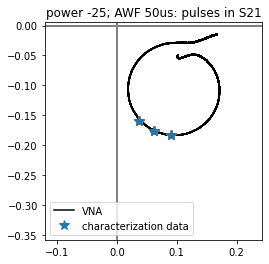

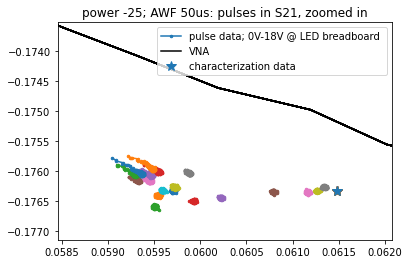

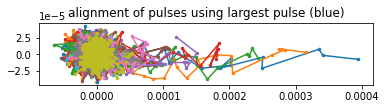

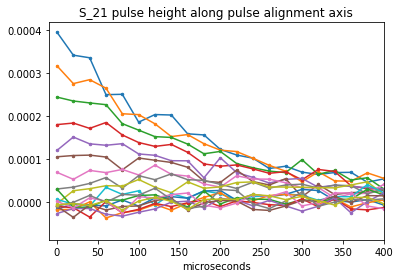

In [266]:
j = 0
reload(Prf)
for NDF_pulse_files,NDF_pulse_vna_files,NDF_char_files in zip(power_NDF_pulse_files,power_NDF_pulse_vna_files,power_NDF_char_files):
    i = 0
    # print(NDF_char_files)
    if len(NDF_pulse_files) != len(NDF_pulse_vna_files):
        NDF_char_files = len(NDF_pulse_files) * NDF_char_files
        NDF_pulse_vna_files = len(NDF_pulse_files) * NDF_pulse_vna_files
    last_width = 0.
    for pulse_file,vna_file,char_file in zip(NDF_pulse_files,NDF_pulse_vna_files,NDF_char_files):
        print(pulse_file)
#         AWF_idx = pulse_file.find('us')
        
#         AWF_string = pulse_file[width_idx-2:width_idx+2]
        AWF_string = NDF_directories[0]
        title_1 = 'power ' + power_directories[j][:-1] + '; AWF ' + AWF_string[4:-1] + ': pulses in S21'
        title_1p5 = 'power ' + power_directories[j][:-1] + '; AWF ' + AWF_string[4:-1] + ': pulses in S21, zoomed in'
        title_1p75 = 'alignment of pulses using largest pulse (blue)'
        # title_2 = 'power ' + power_directories[j][:-1] + ': timestream along rotated axis'    
        title_2 = 'S_21 pulse height along pulse alignment axis'
        clean_pulse_file = pulse_file[:-3] + '_cleaned.h5'
        with h5py.File(clean_pulse_file, "r") as fyle:
            pulse_avg = np.array(fyle["pulse_shape"],dtype=np.complex128)
            pulse_timestream = np.array(fyle["cleaned_data"],dtype=np.complex128)
        with h5py.File(char_file,'r') as fyle:
            char_points = np.array(fyle['means'])
            char_f = np.array(fyle['frequencies'])
            readout_f = char_f[0]
        f,z = PUf.read_vna(vna_file)
        # print(pulse_fs)
        df_f, d1_Q, _, _ = Prf.resonator_basis(pulse_avg,readout_f,f,z,char_f,char_points)#,plot_title='power ' + power_directories[j][:-1] + ' AWF ' + AWF_string)
        df_f_timestream, d1_Q_timestream, _, _ = Prf.resonator_basis(pulse_timestream[:,0],readout_f,f,z,char_f,char_points)
        # plt.axis([0.058, 0.062, -0.19, -0.15])
        
        pulse_avg_mb = pulse_avg - np.mean(pulse_avg[:-20],dtype=np.complex128)
        if i == 0:
            std = np.std(abs(pulse_avg_mb[:-20]),dtype=np.complex128)
            average_angle = np.mean(np.angle(pulse_avg_mb[abs(pulse_avg_mb) > 5*std]))
        pulse_timestream_mb = pulse_timestream[:,0] - np.mean(pulse_avg[:-20],dtype=np.complex128)
        pulse_avg_rotated = pulse_avg_mb * np.exp(-1j*average_angle)
        pulse_timestream_rotated = pulse_timestream_mb * np.exp(-1j*average_angle)
        
        # template = df_f
        # noise = df_f_timestream
        
        template = pulse_avg_rotated.real #pulse_avg_rotated.real
        noise = pulse_timestream_rotated.real
        # print(len(pulse_avg),len(df_f))
        
        with h5py.File(clean_pulse_file, "a") as fyle:
            if 'df_f_template' in fyle.keys():
                del fyle['df_f_template']
            if 'df_f_pulse_noise' in fyle.keys():
                del fyle['df_f_pulse_noise']
            fyle.create_dataset('df_f_template',data = np.asarray(template))
            fyle.create_dataset('df_f_pulse_noise',data = np.asarray(noise))
        if i % 1 == 0:
            label_c = 'characterization data' if i == 0 else None
            label_V = 'VNA' if i == 0 else None
            label_p = 'pulse data; 0V-18V @ LED breadboard ' if i == 0 else None
            plt.figure(title_1)
            plt.plot(pulse_avg.real,pulse_avg.imag,ls='-',marker='.',markersize=5,color='C'+str(i%10))
            plt.plot(z.real,z.imag,color='k',label=label_V)
            plt.plot(char_points.real,char_points.imag,marker='*',markersize=10,ls='',label=label_c,zorder=-5*i+200)
            plt.axhline(0,color='grey')
            plt.axvline(0,color='grey')
            plt.title(title_1)
            width = 30e3 * np.std(pulse_avg.real)
            x_c = np.mean(pulse_avg.real)
            y_c = np.mean(pulse_avg.imag)
            plt.axis([x_c - width/2., x_c + width/2., y_c-width/2., y_c+width/2.])
            ax = plt.gca()
            ax.set_aspect('equal','box')
            plt.legend()
            
            plt.figure(title_1p5)
            plt.plot(pulse_avg.real,pulse_avg.imag,ls='-',marker='.',markersize=5,color='C'+str(i%10),label=label_p,zorder=-5*i+200)
            plt.plot(z.real,z.imag,color='k',label=label_V)
            plt.plot(char_points.real,char_points.imag,marker='*',markersize=10,ls='',label=label_c,zorder=-5*i+200)
            plt.title(title_1p5)
            width = 300 * np.std(pulse_avg.real)
            x_c = np.mean(pulse_avg.real) - 0.001
            y_c = np.mean(pulse_avg.imag) + 0.001
            plt.axis([x_c - width/2., x_c + width/2., y_c-width/2., y_c+width/2.])
            plt.legend()
            # plt.axis([0.055,0.06,-0.175,-0.17])
            # plt.axis([-0.025,-0.023,-0.031,-0.029])
            # plt.savefig('power_' + power_directories[j][:-1] + '_AWF_' + NDF_directories[i][:-1] + '_S21_100mK.png')
            
            plt.figure(title_1p75)
            plt.plot(pulse_avg_rotated.real,pulse_avg_rotated.imag,ls='-',marker='.',markersize=5,color='C'+str(i%10))
            ax = plt.gca()
            ax.set_aspect('equal', 'box')
            plt.title(title_1p75)
        time_window_range = fraction_to_keep * time_btw_pulse *1e6
        time_window = np.arange(0,time_window_range,1/sampling_rate*1e6)
        AWF_idx = AWF_string.find('us')
        current_width = float(AWF_string[AWF_idx-2:AWF_idx])
        plt.figure(title_2)
        radius, arc_length, _, _ = Prf.electronics_basis(pulse_avg)
        # pulse_avg_plot = arc_length
        # pulse_avg_plot = pulse_avg.imag - np.mean(pulse_avg[:20].imag)
        pulse_avg_plot = template
        plt.plot(time_window,pulse_avg_plot,ls='-',marker='.',markersize=5,color='C'+str(i))
        # print((100+last_width,-4e-7),current_width-last_width)
        ax = plt.gca()
        ax.add_patch(mpatches.Rectangle((window_shift*1e6+last_width,-2e-7),current_width-last_width,4e-7,alpha=0.4,color='C'+str(i)))
        plt.xlim([-10, 400])
        plt.xlabel('microseconds')
        plt.title(title_2)
        # plt.ylim([-4e-7,4e-7])
        
        last_width = current_width
                   
        # plt.savefig('power_' + power_directories[j][:-1] + '_d1_Q_100mK.png')
        i += 1
    j += 1
plt.figure(title_1)
plt.savefig('VNA_char_pulse_S21.png',dpi=300,facecolor='white',transparent=False)
plt.figure(title_1p5)
plt.savefig('VNA_char_pulse_S21_zoomed_in.png',dpi=300,facecolor='white',transparent=False)
plt.figure(title_1p75)
plt.savefig('pulse_alignment.png',dpi=300,facecolor='white',transparent=False)
plt.figure(title_2)
plt.savefig('timestream_aligned',dpi=300,facecolor='white',transparent=False)


<font size="5">OF code</font>

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~`
power: -25
analyzing data file: 220815 laser data mid band KID dense/-25/18V 50us/USRP_Laser_20220815_190214.h5
B7 res: 1.0238400724981327
mu = 9.76e-01; sigma = 7.19e-01
analyzing data file: 220815 laser data mid band KID dense/-25/17V 50us/USRP_Laser_20220815_190151.h5
B7 res: 1.0238400724981327
mu = 8.66e-01; sigma = 7.18e-01
analyzing data file: 220815 laser data mid band KID dense/-25/16V 50us/USRP_Laser_20220815_190128.h5
B7 res: 1.0238400724981327
mu = 7.41e-01; sigma = 7.32e-01
analyzing data file: 220815 laser data mid band KID dense/-25/15V 50us/USRP_Laser_20220815_190105.h5
B7 res: 1.0238400724981327
mu = 6.99e-01; sigma = 7.31e-01
analyzing data file: 220815 laser data mid band KID dense/-25/14V 50us/USRP_Laser_20220815_190042.h5
B7 res: 1.0238400724981327
mu = 6.75e-01; sigma = 7.29e-01
analyzing data file: 220815 laser data mid band KID dense/-25/13V 50us/USRP_Laser_20220815_190019.h5
B7 res: 1.0238400724981327
mu = 5.62e-01; sigma = 7.1

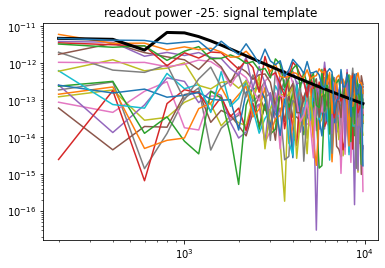

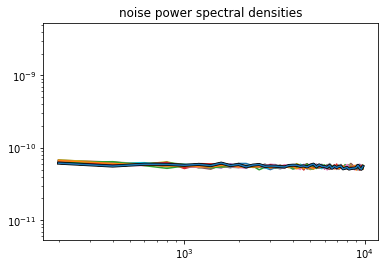

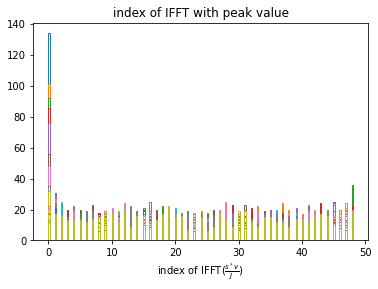

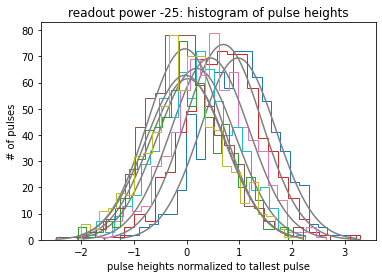

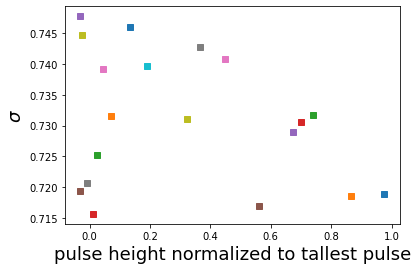

In [245]:
%matplotlib inline

import scipy
reload(Prf)
i = 0
for NDF_pulse_files,NDF_pulse_vna_file in zip(power_NDF_pulse_files,power_NDF_pulse_vna_files):
    print('~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~`')
#     print(power_directories,i)
    print('power: ' + power_directories[i][:-1])
    
    title_1 = 'readout power ' + power_directories[i][:-1] + ': signal template'
    title_2 = 'readout power ' + power_directories[i][:-1] + ': noise power spectral density'
    title_2 = 'noise power spectral densities'
    title_2p25  = 'convolution'
    title_2p5 = 'index of IFFT with peak value'
    title_3 = 'readout power ' + power_directories[i][:-1] + ': histogram of pulse heights'
    title_4 = 'readout power ' + power_directories[i][:-1] + ': sigma vs mu'
    
    mus = []; sigmas = [];mu1s = []; sigma1s = [];mu2s = []; sigma2s = [];
    j = 0
    s_found = False
    for pulse_file in NDF_pulse_files:
        print('=====================')
        print('analyzing data file: ' + pulse_file)
        color = 'C'+str(j%10)
#         print(pulse_file)
        clean_pulse_file = pulse_file[:-3] + '_cleaned.h5'
        with h5py.File(clean_pulse_file, "r") as fyle:
            pulse_avg = np.array(fyle["df_f_template"])
            pulse_noise = np.array(fyle["df_f_pulse_noise"])
            sampling_rate = np.array(fyle['sampling_rate'])

    #     pulse_avg = np.polyval(dtheta_to_energy_fit,pulse_avg)
    #     pulse_noise = np.polyval(dtheta_to_energy_fit,pulse_noise)
    
        N = len(pulse_avg)
        T = N/sampling_rate
        lowest_freq = 1./T
        highest_freq = sampling_rate/2
        if N % 2 == 0:
            f_pos = np.linspace(lowest_freq,highest_freq,N//2)
            f_neg = np.linspace(-(highest_freq-lowest_freq),-lowest_freq,N//2-1)
            
            f = np.concatenate(([0],f_pos,f_neg))
                               
        f_mask = np.logical_and(f > 0, f < 1e4)
    
    
        w = scipy.signal.blackman(N)
#         w = np.ones((N,))
#         w = scipy.signal.hanning(N)
        time = np.linspace(1./sampling_rate,N/sampling_rate,N)
        semilog_fit = np.polyfit(time,pulse_avg,8)
        pulse_fit = np.polyval(semilog_fit,time)
        s_temp = Prf.discrete_FT(pulse_avg)
        if j == 0:
            s = Prf.discrete_FT(pulse_fit)
        # if j <= len(NDF_pulse_files)-5:
            plt.figure(title_1)
            S_mag = abs(s[f_mask]**2)
            plt.plot(f[f_mask],abs(s[f_mask]**2),zorder=-5*j+5,color='k',linewidth=3)
        plt.figure(title_1)
        plt.plot(f[f_mask],abs(s_temp[f_mask]**2),zorder=-5*j+5,color=color)
        
        # print(s.shape)
#         if 'no NDF' in pulse_file:
#             s = Prf.discrete_FT(pulse_fit)
#         elif '12p5' in pulse_file:
#             s = Prf.discrete_FT(pulse_fit)

    #     plt.figure(0)
    #     plt.plot(time,pulse_avg)
    #     plt.plot(time,pulse_fit)

    #     pulse_filter = pulse_avg[::-1]/max(pulse_avg)
    #     plt.figure(10)
    #     plt.plot(pulse_filter,zorder=100-5*i)
    #     filtered_data = scipy.signal.fftconvolve(pulse_noise, pulse_filter, mode="valid")

    #     time = np.linspace(0,len(filtered_data)/sampling_rate,len(filtered_data))
    #     print(time,filtered_data)
    #     plt.figure(1)
    #     plt.plot(time,filtered_data)
    #     plt.xlim([4.005,4.010])
        
        samples_per_pulse = sampling_rate*time_btw_pulse
        window_shift_J = -10e-6
        window_shift_J_idx = int(window_shift_J*sampling_rate)
        J_temp = np.zeros(N)
        # for pulse_i in range(num_pulses):
        for pulse_i in range(pulse_start,int(total_pulses),1):                
            pulse_i_end = int((pulse_i+1)*samples_per_pulse) 
            no_pulse_idx_start = pulse_i_end - N + window_shift_J_idx
            no_pulse_idx_end = pulse_i_end + window_shift_J_idx
            no_pulse_idx_list = np.arange(no_pulse_idx_start,no_pulse_idx_end,1,dtype=int)
            no_pulse_noise_i = pulse_noise[no_pulse_idx_list]
            # if pulse_i == 0:
            #     print(time[no_pulse_idx_start])

            J_temp += abs(Prf.discrete_FT(no_pulse_noise_i))**2 / num_pulses
            
        if j == 0:
            J = J_temp
            plt.figure(title_2)
            plt.plot(f[f_mask],J[f_mask],zorder=-5*j+5,color='k',linewidth=3)
        else:
            plt.figure(title_2)
            plt.plot(f[f_mask],J_temp[f_mask],zorder=-5*j+5,color=color)
            
            
        plt.figure(title_2)
        plt.plot(f[f_mask],J[f_mask],zorder=-5*j+5,color=color)
        denominator = np.sum(abs(s[f_mask])**2/J[f_mask])


        A_hat = np.zeros((num_pulses,3))
        A_max_idx = np.zeros(num_pulses)
        A_hat_max = np.zeros(num_pulses)

        # fraction_to_keep = 0.6
        # window_shift_seconds = 65e-6
        # idcs_keep = np.zeros(int(num_pulses*samples_per_pulse*fraction_to_keep),dtype=int)
        # pulse_avg = np.zeros(int(samples_per_pulse*fraction_to_keep),dtype='complex128')
        # window_shift = int(window_shift_seconds*sampling_rate)
    #     print(pulse_avg)
#         plt.figure(1000+6*j)
#         plt.title(NDF_pulse_files[j][29:34] + ' pulse heights')
#         plt.ylim([-.15,0.4])
#         plt.xlabel('index offset between s/J and v')
#         plt.ylabel('radians')
        b7_res = np.sqrt((denominator**-1))
        print('B7 res: ' + str(b7_res))
        # for pulse_i in np.arange(1,num_pulses,1):
        k = 0
        for pulse_i in range(pulse_start,int(total_pulses),1):
            pulse_idx_start = int(pulse_i*samples_per_pulse) + window_shift
            pulse_idx_end = pulse_idx_start + N
            pulse_idx_list = np.arange(pulse_idx_start,pulse_idx_end,1,dtype=int)
            pulse_noise_i = pulse_noise[pulse_idx_list]
            v = Prf.discrete_FT(pulse_noise_i)
            
            pulse_i_end = int((pulse_i+1)*samples_per_pulse) 
            no_pulse_idx_start = pulse_i_end - N + window_shift_J_idx
            no_pulse_idx_end = pulse_i_end + window_shift_J_idx
            no_pulse_idx_list = np.arange(no_pulse_idx_start,no_pulse_idx_end,1,dtype=int)
            no_pulse_noise_i = pulse_noise[no_pulse_idx_list]
            J_temp = Prf.discrete_FT(no_pulse_noise_i)

            
            numerator = Prf.discrete_IFT(np.conj(s[f_mask])*v[f_mask]/J[f_mask])
            numerator = numerator.real
#             if pulse_i % 50 == 0:
#                 idx_range = 20
#                 plt.plot(np.arange(-idx_range,0,1),numerator[-idx_range:]/denominator,ls='',marker='.',color=color)
#                 plt.plot(np.arange(0,idx_range,1),numerator[:idx_range]/denominator,ls='',marker='.',color=color)
            
#             N = len(pulse_noise_i)
            max_numerator = max(numerator)
            max_idx = np.argwhere(numerator == max_numerator)
#             if pulse_i %500 == 0:
#                 print(max_idx)
            A_max_idx[k] = max_idx 
#             num_to_check = 3
#             idcs_to_check_1 = np.arange(0,num_to_check,1)
#             idcs_to_check_2 = np.arange(N-1,N-num_to_check,-1)
#             idcs_to_check = np.concatenate((idcs_to_check_1,idcs_to_check_2))
#             if max_idx in idcs_to_check or True:
#                 A_hat[pulse_i] = max_numerator/denominator
#             else:
#             [numerator[-1],numerator[0],numerator[1]]
            A_hat[k,0] = numerator[0]/denominator
            A_hat[k,1] = numerator[-1]/denominator
            A_hat[k,2] = numerator[1]/denominator
            A_hat_max[k] = max(numerator)/denominator
            k += 1
#             A_std = np.std(numerator.real/denominator)
#             if max_numerator/denominator > 2*A_std:
#                 A_hat[pulse_i] = max_numerator/denominator
#             else:
#                 A_hat[pulse_i] = numerator[0].real/denominator

    #         pulse_peak = max(filtered_data[pulse_idx_list])
    #         idx_peak = np.argmax(filtered_data[pulse_idx_list])
    #         A_hat[pulse_i] = max(filtered_data[pulse_idx_list])
    #         print(idx_peak)
    #         A_hat[pulse_i] = filtered_data[pulse_idx_list][1996]
#         print(A_hat[0:10])
        (mu, sigma) = scipy.stats.norm.fit(A_hat[:,0])
        (mu1, sigma1) = scipy.stats.norm.fit(A_hat[:,1])
        (mu2, sigma2) = scipy.stats.norm.fit(A_hat[:,2])
    
        (mu_max, sigma_max) = scipy.stats.norm.fit(A_hat_max)
        print('mu = ' + "{:.2e}".format(mu) + '; sigma = ' + "{:.2e}".format(sigma))
#         try:            
        if not 'no NDF' in pulse_file:
            plt.figure(title_2p5)
            n, bins, patches = plt.hist(A_max_idx,bins=N,fill=False,histtype='step',label='radians',color=color)
            if j % 3 == 0:
                plt.figure(title_3)
                n, bins, patches = plt.hist(A_hat[:,0],bins=25,fill=False,histtype='step',label='radians',color=color)
                plt.plot(np.linspace(bins[0],bins[-1],100),\
                         len(A_hat)*(bins[1]-bins[0])*scipy.stats.norm.pdf(np.linspace(bins[0],bins[-1],100),mu,sigma),\
                         c='gray')
            mus.append(mu); sigmas.append(sigma)
            mu1s.append(mu1); sigma1s.append(sigma1)
            mu2s.append(mu2); sigma2s.append(sigma2)

            plt.figure(title_4)
            if j % 2 == 0:
                marker = 's'
#                     print(pulse_file)
            else:
                marker = 's'
            plt.plot(mu,sigma,color=color,ls='',marker=marker)
#             plt.plot(mu1,sigma1,color=color,ls='',marker='*')
#             plt.plot(mu2,sigma2,color=color,ls='',marker='x')
            # plt.plot(mu_max,sigma_max,color=color,ls='',marker='.')

#         except:
#             pass
        j += 1
        
    plt.figure(title_1)
    ax = plt.gca(); ax.set_yscale('log'); ax.set_xscale('log')
    plt.title(title_1)
    
    plt.figure(title_2)
    ax = plt.gca(); ax.set_yscale('log'); ax.set_xscale('log')
    J_avg = np.mean(J)
    plt.ylim([1e-1*J_avg,1e2*J_avg])
    plt.title(title_2)
    
    plt.figure(title_2p5)
    plt.title(title_2p5)
    plt.xlabel(r'index of IFFT($\frac{s^*v}{J}$)')
    
    plt.figure(title_3)
    plt.title(title_3)
    plt.xlabel('pulse heights normalized to tallest pulse')
    plt.ylabel('# of pulses')
#     plt.xlim([-0.25,0.5])
    # ax = plt.gca(); ax.set_yscale('log');
    # plt.ylim([10**-1,10**3])

    plt.figure(title_4)
#     plt.title(title_4)
    plt.xlabel('pulse height normalized to tallest pulse',fontsize=18)
    plt.ylabel('$\sigma$',fontsize=18)
    # plt.xlim([-0.05,0.1])

    def f(mu,sigma_0,r):
        return np.sqrt(sigma_0**2 + (mu)*r)

    import scipy
    p0 = [1e-1,1e-2]
#     f_fit_vals,_ = scipy.optimize.curve_fit(f,mus[1:],sigmas[1:],p0,bounds=[(15*(0.008/2.6),7e-3),(40*(0.008/2.6),0.1)])
#     f_fit_vals,_ = scipy.optimize.curve_fit(f,mus[1:],sigmas[1:],p0)
#     f_fit_vals1,_ = scipy.optimize.curve_fit(f,mu1s[1:],sigma1s[1:],p0)
#     f_fit_vals2,_ = scipy.optimize.curve_fit(f,mu2s[1:],sigma2s[1:],p0)
#     #     for i in range(len(mus)):
#     #         print(f_fit_vals[0],mus[i]*f_fit_vals[1])

#     sigma_0_E_pub = abs(f_fit_vals[0])/(f_fit_vals[1]/2.6)
#     r_E = f_fit_vals[1]/2.6
#     print('energy resolution estimate is: ' + str(sigma_0_E_pub))
#     sigma_0_E = abs(f_fit_vals1[0])/(f_fit_vals1[1]/2.6)
#     r_E = f_fit_vals1[1]/2.6
#     print(sigma_0_E)
#     sigma_0_E = abs(f_fit_vals2[0])/(f_fit_vals2[1]/2.6)
#     r_E = f_fit_vals2[1]/2.6
#     print(sigma_0_E)

    # mu_plot = np.linspace(0,0.25,100)
#     plt.figure(title_4)
#     plt.plot(mus,np.array(sigmas))
#     plt.plot(mu_plot,f(mu_plot,*f_fit_vals),label='$\sigma_0$='+str(round(sigma_0_E_pub,1))+'eV')
#     custom_lines = [\
#                 #Line2D([0], [0],color='k',ls='',marker='.',label='max of IFT'),\
#                 #Line2D([0], [0], color='k',alpha=0.5, ls='dashdot',label='radius and arc length directions'),\
#                 Line2D([0], [0],color='k',ls='',marker='s',label='index 0'),]
#                 #Line2D([0], [0], ls='',color='C1', marker='.',label='off resonance timestream')]
# #     plt.legend(handles=custom_lines)
#     plt.legend(loc='lower right',fontsize=14)
#     plt.ylim([0,0.05])
#     plt.tight_layout()
#     plt.savefig('sigma_vs_mu.png',dpi=200)
#     plt.plot(mu1s,sigma1s)
#     plt.plot(mu_plot,f(mu_plot,*f_fit_vals1))
#     plt.plot(mu2s,sigma2s)
#     plt.plot(mu_plot,f(mu_plot,*f_fit_vals2))
    i += 1